In [ ]:
! pip install --upgrade scipy

In [646]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [654]:
import matplotlib.pyplot as plt
        
def show_rgb(*img, figsize=(8, 3)):
    plt.figure(figsize=figsize)
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.show()

def read(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


def read_rgb(path):
    x = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

def neg(img):
    return 255 - img

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def resize(img, size=(100, 100)):
    return cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)

def erode(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(img, kernel, iterations=it)

def dilate(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.dilate(img, kernel, iterations=it)

def blur(x, it=1):
    for _ in range(it):
        x = cv2.GaussianBlur(x, (3, 3), cv2.BORDER_DEFAULT)
    return x

### Fuzzy Classes

In [664]:
def f(i):
    return float("{:.2f}".format(i))

def prod(a, b):
    return a+b - a*b

def tri(x, color_intensity):
    scale = color_intensity/255
    if x <= 0.5:
        return scale * 2 * x
    else:
        return scale * 2 * (1-x)
    
def tri_min(x, color_intensity, minimum=0.1):
    peak = color_intensity/255
    add = abs(0.5-x)/0.5 * minimum
    return min(minimum + (peak - minimum) * (0.5 - np.abs(0.5-x)) * 2, peak)

class FuzzyColor:
    def __init__(self, rgb, fn=tri_min, conorm_fn=prod):
        # save original representation 
        r, g, b = rgb
        self._set_fn = fn
        self._conorm_fn = conorm_fn
        
        # initialize representation
        self._fuzzy_color = {}
        for i in np.arange(0.0, 1.01, 0.01):
            fi = f(i)
            self._fuzzy_color[fi] = 0.0
        
        # red 
        tmp = {}
        for i in np.arange(0.0, 1.01, 0.01):
            fi = f(i)
            x = fn(fi, r)
            tmp[fi] = x

        # first range
        red = tmp.copy()
        xs = np.array(list(red.keys()))
        ys = [red[x] for x in xs]
        xs*=0.66
        xs-=0.33
        xs = [f(x) for x in xs]
        red = dict(zip(xs, ys))

        for i in np.arange(0.0, 0.34, 0.01):
            fi = f(i)
            self._fuzzy_color[fi] = red[fi]
        
        # second range
        red = tmp.copy()
        xs = np.array(list(red.keys()))
        ys = [red[x] for x in xs]
        xs*=0.66
        xs+=0.66
        xs = [f(x) for x in xs]
        red = dict(zip(xs, ys))
        
        for i in np.arange(0.67, 1.01, 0.01):
            fi = f(i)
            self._fuzzy_color[fi] = red[fi]
        
        # green
        tmp = {}
        for i in np.arange(0.0, 1.01, 0.01):
            fi = f(i)
            x = fn(fi, g)
            tmp[fi] = x
        
        green = tmp.copy()
        xs = np.array(list(green.keys()))
        ys = [green[x] for x in xs]
        xs*=0.666
        xs = [f(x) for x in xs]
        green = dict(zip(xs, ys))
        
        for i in np.arange(0.0, 0.68, 0.01):
            fi = f(i)
            self._fuzzy_color[fi] = max(self._fuzzy_color.get(fi) or 0, green[fi])
            
        # blue 
        # XXX Quantization error in blue channel
        # FIXME use fidelity of 1000 to fix
        tmp = {}
        for i in np.arange(0.0, 1.01, 0.01):
            fi = f(i)
            x = fn(fi, b)
            tmp[fi] = x
            
        blue = tmp.copy()
        
        xs = np.array(list(blue.keys()))
        ys = [blue[x] for x in xs]
    
        xs*=0.67
        xs+=0.33
        xs = [f(x) for x in xs]
        blue = dict(zip(xs, ys))
        for i in np.arange(0.33, 1.01, 0.01):
            fi = f(i)
            self._fuzzy_color[fi] = max(self._fuzzy_color.get(fi) or 0, blue[fi])
            
    def plot(self):
        show(self)
        
    def power(self, n):
        xs = self._fuzzy_color.keys()
        ys = [self._fuzzy_color[c]**n for c in xs]
        _map = dict(zip(xs, ys))
        r, g, b = FuzzyColor.to_rgb(_map)
        return FuzzyColor((r, g, b), self._set_fn, self._conorm_fn)
            
    
    def __repr__(self):
        r, g, b = self.get_rgb()
        return str({
            'r': r,
            'g': g,
            'b': b
        })
    
    def get_rgb(self):
        r, g, b = FuzzyColor.to_rgb(self._fuzzy_color)
        return r, g, b
    
    def to_rgb(_map):
        r, g, b = _map[0.00], _map[0.33], _map[0.66]
        r = round(r*255)
        g = round(g*255)
        b = round(b*255)
        return r, g, b

    def __add__(self, other):
        assert self._set_fn == other._set_fn
        assert self._conorm_fn == other._conorm_fn
        
        k = self._fuzzy_color.keys()
        _map = {}
        for i in k:
            av = self._fuzzy_color[i]
            bv = other._fuzzy_color[i]
            cv = self._conorm_fn(av, bv)
            _map[i] = cv

        r, g, b = _map[0.00], _map[0.33], _map[0.66]
        r = round(r*255)
        g = round(g*255)
        b = round(b*255)
        return FuzzyColor((r, g, b), self._set_fn, self._conorm_fn)
        
        
def show(*fc, figsize=(8, 3)):
    plt.figure(figsize=figsize)
    for f in fc:
        xs = f._fuzzy_color.keys()
        ys = [f._fuzzy_color[x] for x in xs]
        plt.plot(xs, ys)
    plt.legend(range(len(fc)))
    plt.xlim((0, 1))
    plt.ylim((0, 1))

In [726]:
%%time
r1 = FuzzyColor((255, 0, 0))

CPU times: user 4.19 ms, sys: 149 µs, total: 4.34 ms
Wall time: 4.26 ms


CPU times: user 24.8 ms, sys: 3.89 ms, total: 28.7 ms
Wall time: 25.8 ms


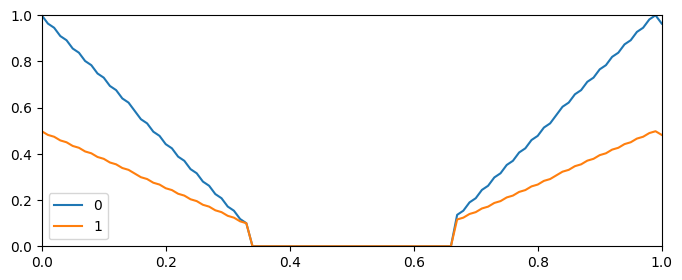

In [725]:
%%time
r1 = FuzzyColor((255, 0, 0))
r2 = FuzzyColor((127, 0, 0))
show(r1, r2)

{'r': 255, 'g': 26, 'b': 250}

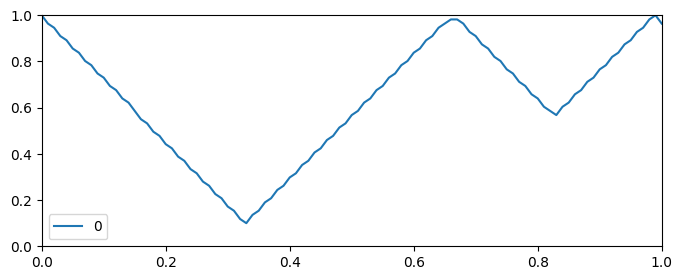

In [488]:
red_and_blue = FuzzyColor((255, 0, 255), tri_min)
red_and_blue.plot()
red_and_blue

({'r': 200, 'g': 26, 'b': 0},
 {'r': 26, 'g': 200, 'b': 29},
 {'r': 206, 'g': 206, 'b': 29})

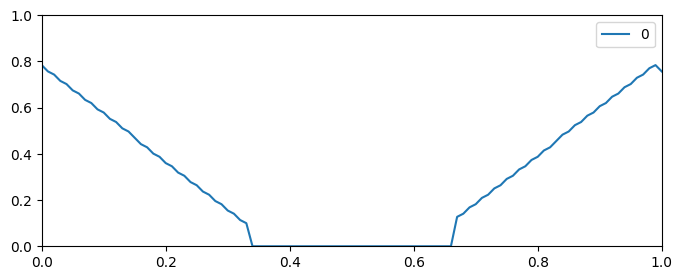

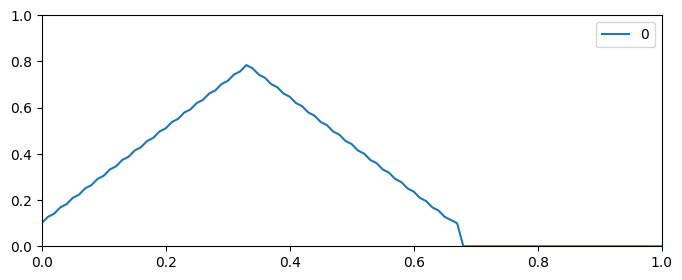

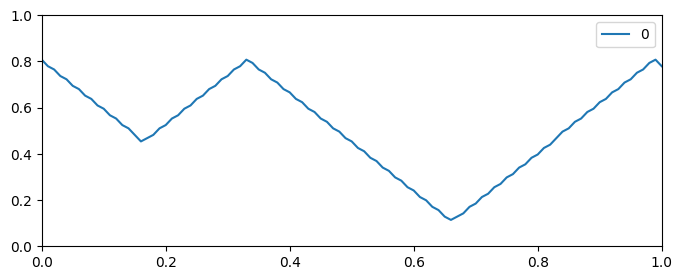

In [489]:
red = FuzzyColor((200, 0, 0), tri_min)
green = FuzzyColor((0, 200, 0), tri_min)
red_green = red + green
red.plot()
green.plot()
red_green.plot()
(red, green, red_green)

#### Fuzzy Image

In [782]:
class FuzzyImage:
    def __init__(self, rgb_image, set_fn=tri_min, conorm_fn=prod, fuzzy_image=None):
        if fuzzy_image is None:
            self.input = rgb_image
            self.set_fn = set_fn
            self.conorm_fn = conorm_fn

            from collections import defaultdict
            self.fuzzy_image = defaultdict(dict)
            for y in range(rgb_image.shape[0]):
                for x in range(rgb_image.shape[1]):
                    pixel = rgb_image[y][x]
                    fuzzyPixel = FuzzyColor(pixel, set_fn, conorm_fn)
                    self.fuzzy_image[y][x] = fuzzyPixel
        else:
            import copy
            self.input = fuzzy_image.input.copy()
            self.set_fn = fuzzy_image.set_fn
            self.conorm_fn = fuzzy_image.conorm_fn
            self.fuzzy_image = copy.deepcopy(fuzzy_image.fuzzy_image)
    
    def __getitem__(self, key):
        return self.fuzzy_image[key]

    def __setitem__(self, key, value):
        self.fuzzy_image
    
    @property
    def shape(self):
        return self.input.shape
    
    def get_rgb(self):
        output = self.input.copy()
        for y in range(output.shape[0]):
            for x in range(output.shape[1]):
                output[y][x] = self.fuzzy_image[y][x].get_rgb()
    
        return output
    
    def copy(self):
        return FuzzyImage(rgb_image=None, fuzzy_image=self)

#### Test fuzzy algo

In [788]:
# fuzzy-algo
def max_conorm(a, b):
    return max(a, b)

def fuzzy_denoise(image, set_fn=tri_min, conorm_fn=prod):
    fuzzy_input = FuzzyImage(image, set_fn=set_fn, conorm_fn=conorm_fn)
    fuzzy_output = FuzzyImage(image, set_fn=set_fn, conorm_fn=conorm_fn)
    for y in range(fuzzy_input.shape[0]):
        for x in range(fuzzy_input.shape[1]):
            neighbours = []
            if 0 <= y+1 < fuzzy_input.shape[0]:
                n = fuzzy_input[y+1][x]
                neighbours.append(n)

            if 0 <= y-1 < fuzzy_input.shape[0]:
                n = fuzzy_input[y-1][x]
                neighbours.append(n)

            if 0 <= x+1 < fuzzy_input.shape[1]:
                n = fuzzy_input[y][x+1]
                neighbours.append(n)

            if 0 <= x-1 < fuzzy_input.shape[1]:
                n = fuzzy_input[y][x-1]
                neighbours.append(n)

            if len(neighbours) > 0:
                result = neighbours[0]
                for i in range(1, len(neighbours)):
                    result += neighbours[i]

                averaged = result.power(len(neighbours))
                fuzzy_output[y][x] = averaged
                  
    return fuzzy_output.get_rgb()

In [789]:
%%time
r = fuzzy_denoise(noisy, conorm_fn=conorm_fn)

CPU times: user 46.2 s, sys: 1.23 s, total: 47.5 s
Wall time: 46.8 s


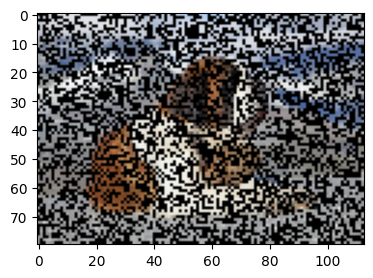

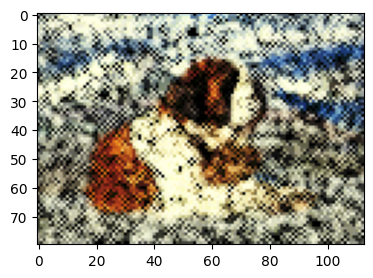

In [791]:
show_rgb(noisy)
show_rgb(r)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:11<00:00, 43.11s/it]


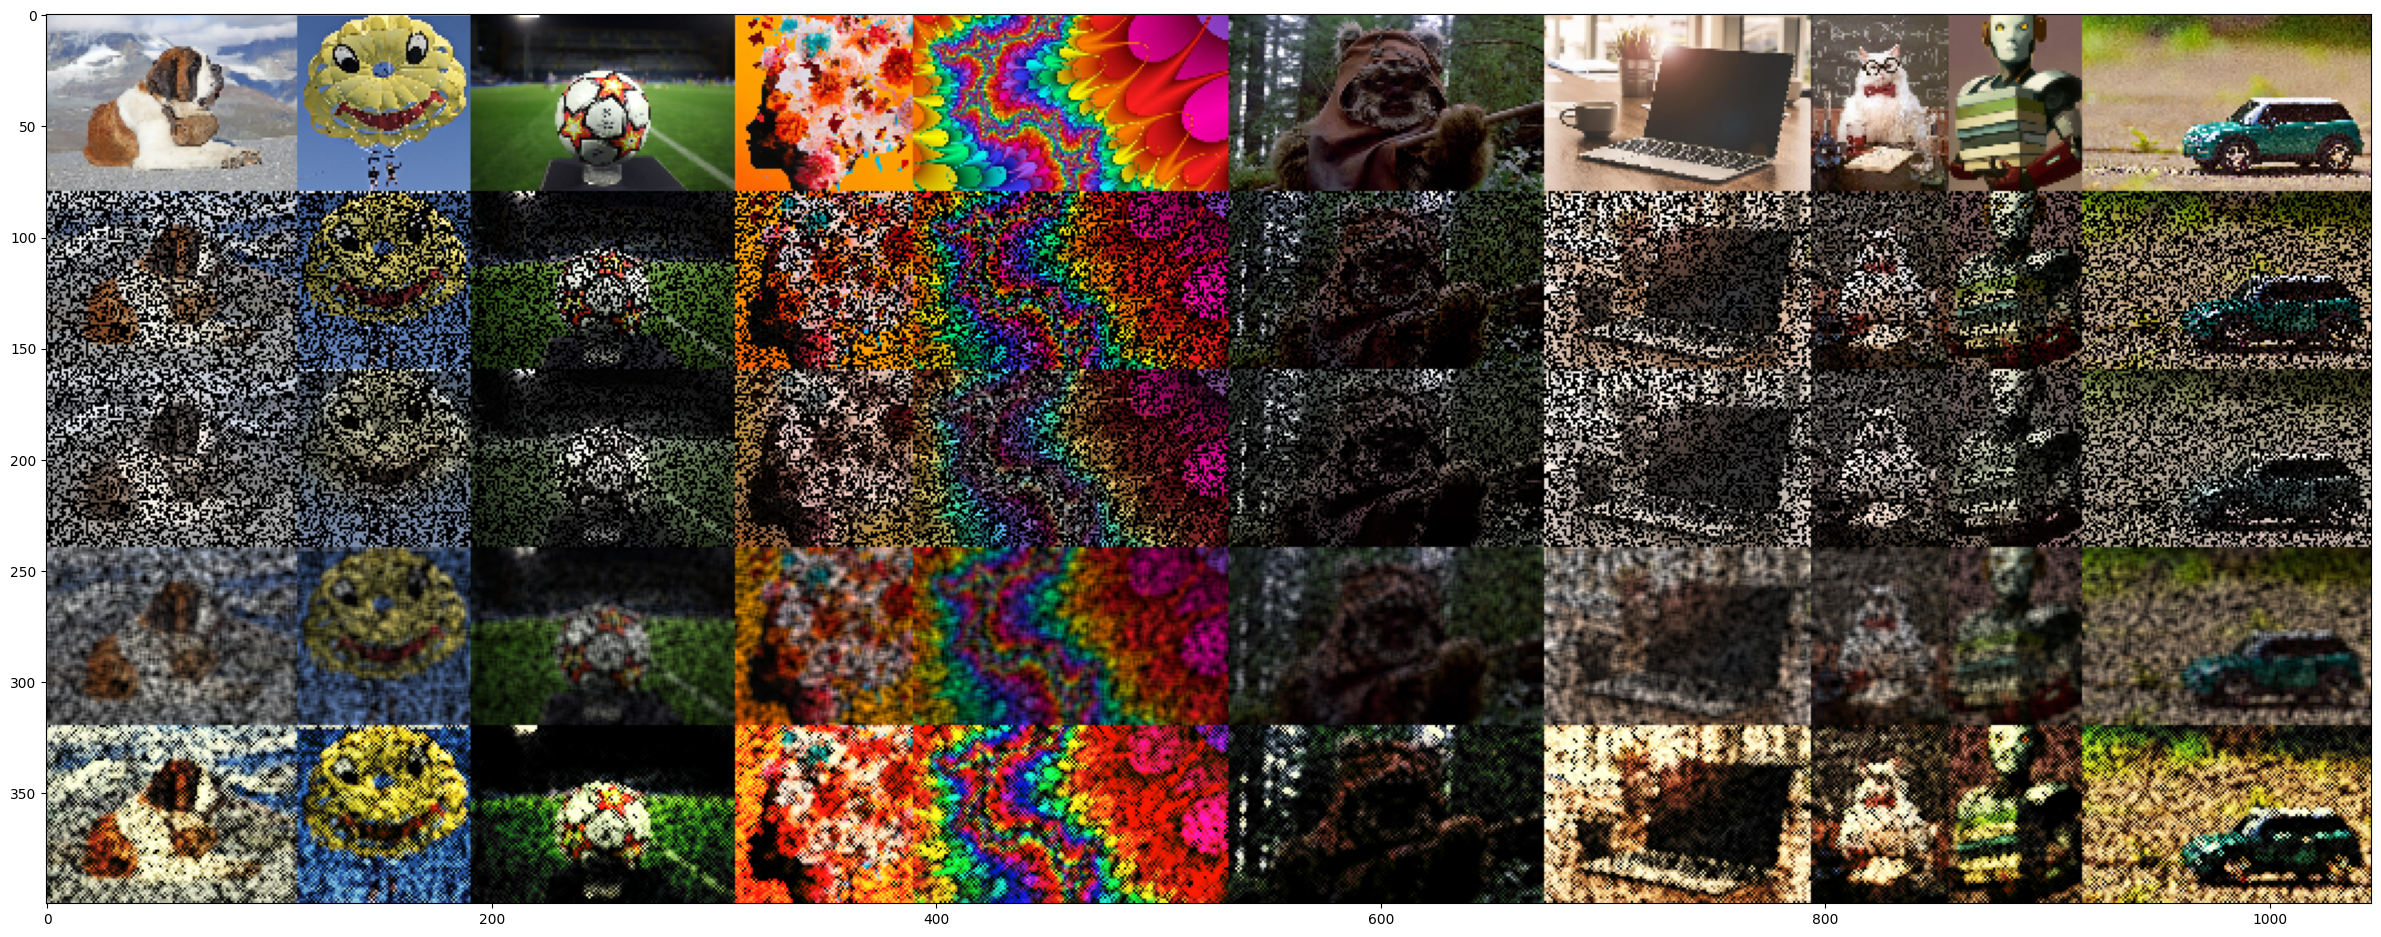

In [793]:
max_h = 80
conorm_fn = prod
noise_level = 0.5

tests = [x for x in os.listdir('.') if x.endswith('.jpg') or x.endswith('.png') or x.endswith('.jpeg')]
vstacks = []
for t in tqdm(tests):
    # Read and resize image
    img = read_rgb(t)
    size_h = max_h
    coeff = img.shape[1]/img.shape[0]
    size_w = int(size_h * coeff)
    img = resize(img, size=(size_w, size_h))
    
    # Introduce noise
    noise = np.random.random(size=(img.shape[0], img.shape[1]))
    mask = noise < noise_level
    noisy = img.copy()
    noisy[mask, :] = (0, 0, 0)

    # Denoise openCV 
    denoised_nlmeans = cv2.fastNlMeansDenoisingColored(noisy,None,20,20,7,21) 

    # Denoise gaussian (blur)
    denoised_blur = blur(noisy)

    # Denoised with fuzzy logic
    denoised_fuzzy = fuzzy_denoise(noisy, conorm_fn=conorm_fn)
    vstack = np.vstack([img, noisy, denoised_nlmeans, denoised_blur, denoised_fuzzy])
    vstacks.append(vstack)

grid = np.hstack(vstacks)
show_rgb(grid, figsize=(30, 30))

In [617]:
# # Gaussian stuff
# import scipy.stats
# from scipy.stats import norm

# def gauss(x, color_intensity):
#     m = 0.5
#     epsilon = 1e-1
#     sigma = (1 - (color_intensity-epsilon)/255)**3
    
#     a = np.e**(-1*(((x-m)**2)/(2*(sigma**2))))
#     b = sigma * np.sqrt(2*np.pi)
#     pdf_y = a/b
    
#     ts = []
#     for i in np.arange(0.0, 1.01, 0.01):
#         ts.append(gauss_2(i, sigma, color_intensity))
#     m = np.array(ts).sum()

#     pmf_y = pdf_y/m
#     return pmf_y

# def gauss_2(x, sigma, color_intensity):
#     epsilon=1e-1
#     return norm.pdf(x, 0.5, sigma)

# from tqdm import tqdm
# %%time
# # Gauss-mine
# ts = []
# xs = np.arange(0.0, 1.01, 0.01)
# for i in xs:
#     t = gauss(i, 230)
#     ts.append(t)
# plt.plot(xs, ts)

# maxes = []
# intensities = range(0, 256)
# for intensity in tqdm(range(0, 256)):
#     ts = []
#     xs = np.arange(0.0, 1.01, 0.01)
#     for i in xs:
#         t = gauss(i, intensity)
#         ts.append(t)
#     maxes.append(max(ts))

# plt.plot(intensities, maxes)

# # r1 = FuzzyColor((255, 0, 0), tri)
# r2 = FuzzyColor((200, 200, 200), gauss)
# show(r2)